In [11]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy.linalg as lin

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

import statsmodels.tsa.stattools as st

# Implementation of Vanilla BPS

In [ ]:
def next_bounce_time_gaussian(x, v, Cinv, Z):
    A = v @ Cinv @ x
    B = v @ Cinv @ v
    T0 = np.maximum(0.0, -A/B)
        
    tau = (-A + np.sqrt(A*A + 2*A*B*T0 + B*B*T0*T0 + 2*B*Z))/B
    
    return tau

In [ ]:
def next_refresh_time(lambda_refresh, Z):
    return Z/lambda_refresh

In [ ]:
def bounce(v, x, Cinv):
    z = Cinv @ x
    A = np.dot(v, z)
    B = np.dot(z, z)
    return v - 2.0*(A/B)*z

In [ ]:
def refresh_velocity(d):
    return np.random.randn(d)

In [ ]:
def bps_standard(C, x0, v0, lambda_refresh, T, num_samples):
    d = x0.shape[0]
    Cinv = np.linalg.inv(C)

    sample_mesh  = np.linspace(0, T, num_samples)

    t = 0.0

    refresh_count = 0
    reflect_count = 0
    
    x_sample = np.zeros((len(sample_mesh), d))
    v_sample = np.zeros((len(sample_mesh), d))
    t_sample = np.zeros(len(sample_mesh))
    num_reflect = np.zeros(len(sample_mesh))
    num_refresh = np.zeros(len(sample_mesh))

    erg_av  = 0.0
    erg_var = 0.0

    sample_index = 0
    
    x = x0
    v = v0

    while (t < T):    
        tau_bounce = next_bounce_time_gaussian(x, v, Cinv, -np.log(np.random.rand()))
        tau_refresh = next_refresh_time(lambda_refresh, -np.log(np.random.rand()))

        tau_min = np.minimum(tau_bounce, tau_refresh)
        
        #Generate the ergodic averages
        erg_av = erg_av + x*tau_min + 0.5*v*tau_min**2
        erg_var = erg_var +  x*x*tau_min + v*x*tau_min**2 + (1.0/3)*v*v*tau_min**3

        #Generate the regular sample of x, v, t along the trajectory
        while ((sample_index < num_samples) and (t + tau_min > sample_mesh[sample_index])):
            x_sample[sample_index,:] = x + (sample_mesh[sample_index] - t)*v
            v_sample[sample_index, :] = v
            t_sample[sample_index] = t
            
            num_reflect[sample_index] = reflect_count
            num_refresh[sample_index] = refresh_count
            
            reflect_count = 0
            refresh_count = 0
            sample_index = sample_index + 1
            
        #Store switching information

        t = t + tau_min
        x = x + tau_min*v

        if (tau_bounce < tau_refresh):
            v = bounce(v, x, Cinv)
            reflect_count = reflect_count + 1
        else:
            v = refresh_velocity(d)
            refresh_count = refresh_count + 1
        
    erg_av = erg_av/t
    erg_var = erg_var/t
    
    return(erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh)

In [ ]:
d = 2
C = np.diag(np.ones(d))
Cinv = np.linalg.inv(C)
x0 = np.random.randn(d)
v0 = np.random.randn(d)
T = 100000.0
lambda_refresh = 0.1

num_samples = 100000

erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_standard(C, x0, v0, lambda_refresh, T, num_samples)


In [ ]:
erg_av, erg_var

In [ ]:
plt.hist2d(x_sample[:,0], x_sample[:,1], bins=100);

# High dimensional scaling of BPS

In [ ]:
def refresh_velocity_generalised(P):
    return np.random.multivariate_normal(np.zeros(P.shape[0]), P)

In [ ]:
def bounce_generalised(v, x, P, Cinv):
    z = Cinv @ x
    A = np.dot(v, z)
    B = np.dot(z, P @ z)
    return v - 2.0*(A/B)* (P @ z)

In [ ]:
def bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples):
    d = x0.shape[0]
    Cinv = np.diag(1.0/np.diag(C))
    P = np.diag(np.diag(C)**eta)
    
    sample_mesh  = np.linspace(0, T, num_samples)

    t = 0.0

    refresh_count = 0
    reflect_count = 0
    
    x_sample = np.zeros((len(sample_mesh), d))
    v_sample = np.zeros((len(sample_mesh), d))
    t_sample = np.zeros(len(sample_mesh))
    num_reflect = np.zeros(len(sample_mesh))
    num_refresh = np.zeros(len(sample_mesh))

    erg_av  = 0.0
    erg_var = 0.0

    sample_index = 0
    
    x = x0
    v = v0

    while (t < T):    
        tau_bounce = next_bounce_time_gaussian(x, v, Cinv, -np.log(np.random.rand()))
        tau_refresh = next_refresh_time(lambda_refresh, -np.log(np.random.rand()))

        tau_min = np.minimum(tau_bounce, tau_refresh)
        
        #Generate the ergodic averages
        erg_av = erg_av + x*tau_min + 0.5*v*tau_min**2
        erg_var = erg_var +  x*x*tau_min + v*x*tau_min**2 + (1.0/3)*v*v*tau_min**3

        #Generate the regular sample of x, v, t along the trajectory
        while ((sample_index < num_samples) and (t + tau_min > sample_mesh[sample_index])):
            x_sample[sample_index,:] = x + (sample_mesh[sample_index] - t)*v
            v_sample[sample_index, :] = v
            t_sample[sample_index] = t
            
            num_reflect[sample_index] = reflect_count
            num_refresh[sample_index] = refresh_count
            
            reflect_count = 0
            refresh_count = 0
            sample_index = sample_index + 1
            
        #Store switching information

        t = t + tau_min
        x = x + tau_min*v

        if (tau_bounce < tau_refresh):
            v = bounce_generalised(v, x, P, Cinv)
            reflect_count = reflect_count + 1
        else:
            v = refresh_velocity_generalised(P)
            refresh_count = refresh_count + 1
        
    erg_av = erg_av/t
    erg_var = erg_var/t
    
    return(erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh)

In [ ]:
d = 3
C = np.diag([1.0/(i+1)**2 for i in np.arange(d)])
x0 = np.random.randn(d)
v0 = np.random.randn(d)
T = 200000.0
lambda_refresh = 0.1
eta  = 0.0

num_samples = 100000

erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples)


In [ ]:
plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ len(x_sample[:,0])))
plt.title("ergodic average of mean")
plt.show()
plt.plot(np.cumsum(num_reflect)/np.arange(1, 1+ len(num_reflect)))
plt.title("Avg number of reflections")
plt.show()
plt.plot(st.acf(x_sample[:,0],unbiased=True))
plt.title("ACF plot")
plt.show()

In [ ]:
eta  = 1.0
erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples)
plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ len(x_sample[:,0])))
plt.title("ergodic average of mean")
plt.show()
plt.plot(np.cumsum(num_reflect)/np.arange(1, 1+ len(num_reflect)))
plt.title("Avg number of reflections")
plt.show()
plt.plot(st.acf(x_sample[:,0],unbiased=True))
plt.title("ACF plot")
plt.show()

In [ ]:
eta  = 2.0
erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples)
plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ len(x_sample[:,0])))
plt.title("ergodic average of mean")
plt.show()
plt.plot(np.cumsum(num_reflect)/np.arange(1, 1+ len(num_reflect)))
plt.title("Avg number of reflections")
plt.show()
plt.plot(st.acf(x_sample[:,0],unbiased=True))
plt.title("ACF plot")
plt.show()

In [ ]:
eta  = 5.0
erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples)
plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ len(x_sample[:,0])))
plt.title("ergodic average of mean")
plt.show()
plt.plot(np.cumsum(num_reflect)/np.arange(1, 1+ len(num_reflect)))
plt.title("Avg number of reflections")
plt.show()
plt.plot(st.acf(x_sample[:,0],unbiased=True))
plt.title("ACF plot")
plt.show()

# Numerical experiments

In [ ]:
def compute_errors(erg_av, erg_var, C):
    av_err = np.linalg.norm(erg_av)
    var_err = np.linalg.norm(erg_var - np.diag(C))
    
    return (av_err, var_err)
    
def run_experiment(d, eta, burnin, fname):
    C = np.diag([1.0/(i+1)**2 for i in np.arange(d)])
    x0 = np.random.randn(d)
    v0 = np.random.randn(d)
    T = 100000.0
    lambda_refresh = 0.1

    num_samples = 10000

    erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples)
    
    av_err, var_err = compute_errors(erg_av, erg_var, C)
        
    plt.subplot(2,2,1)
    plt.plot(np.cumsum(x_sample[burnin:,0])/np.arange(1, 1+ len(x_sample[burnin:,0])))

    plt.subplot(2,2,2)
    plt.plot(np.cumsum(num_reflect[burnin:])/np.arange(1, 1+ len(num_reflect[burnin:])))

    plt.subplot(2,2,3)
    plt.plot(st.acf(x_sample[burnin:,0],unbiased=True))

    plt.suptitle("d = %d, eta = %1.2f, av_err = %f, var_err = %f"%(d, eta, av_err, var_err))
    plt.tight_layout()
    plt.savefig(fname+".png",dpi=199)
    
    np.savetxt(fname+".txt", (d, eta, av_err, var_err, np.mean(num_reflect[burnin:])))
    
    
    plt.clf()

In [ ]:
run_experiment(1, 0.0, 500,"figures/d1_0");
run_experiment(1, 1.0, 500,"figures/d1_1");
run_experiment(1, 2.0, 500,"figures/d1_2");
run_experiment(1, 3.0, 500,"figures/d1_3");
run_experiment(1, 4.0, 500,"figures/d1_4");

run_experiment(10, 0.0, 500,"figures/d2_0");
run_experiment(10, 1.0, 500, "figures/d2_1");
run_experiment(10, 2.0, 500, "figures/d2_2");
run_experiment(10, 3.0, 500, "figures/d2_3");
run_experiment(10, 4.0, 500, "figures/d2_4");

run_experiment(20, 0.0, 500, "figures/d3_0");
run_experiment(20, 1.0, 500, "figures/d3_1");
run_experiment(20, 2.0, 500, "figures/d3_2");
run_experiment(20, 3.0, 500, "figures/d3_3");
run_experiment(20, 4.0, 500, "figures/d3_4");

run_experiment(30, 0.0, 500, "figures/d4_0");
run_experiment(30, 1.0, 500, "figures/d4_1");
run_experiment(30, 2.0, 500, "figures/d4_2");
run_experiment(30, 3.0, 500, "figures/d4_3");
run_experiment(30, 4.0, 500, "figures/d4_4");

run_experiment(40, 0.0, 500, "figures/d5_0");
run_experiment(40, 1.0, 500, "figures/d5_1");
run_experiment(40, 2.0, 500, "figures/d5_2");
run_experiment(40, 3.0, 500, "figures/d5_3");
run_experiment(40, 4.0, 500, "figures/d5_4");

run_experiment(50, 0.0, 500, "figures/d6_0");
run_experiment(50, 1.0, 500, "figures/d6_1");
run_experiment(50, 2.0, 500, "figures/d6_2");
run_experiment(50, 3.0, 500, "figures/d6_3");
run_experiment(50, 4.0, 500, "figures/d6_4");

run_experiment(60, 0.0, 500, "figures/d7_0");
run_experiment(60, 1.0, 500, "figures/d7_1");
run_experiment(60, 2.0, 500, "figures/d7_2");
run_experiment(60, 3.0, 500, "figures/d7_3");
run_experiment(60, 4.0, 500, "figures/d7_4");

run_experiment(70, 0.0, 500, "figures/d8_0");
run_experiment(70, 1.0, 500, "figures/d8_1");
run_experiment(70, 2.0, 500, "figures/d8_2");
run_experiment(70, 3.0, 500, "figures/d8_3");
run_experiment(70, 4.0, 500, "figures/d8_4");

run_experiment(80, 0.0, 500, "figures/d9_0");
run_experiment(80, 1.0, 500, "figures/d9_1");
run_experiment(80, 2.0, 500, "figures/d9_2");
run_experiment(80, 3.0, 500, "figures/d9_3");
run_experiment(80, 4.0, 500, "figures/d9_4");

run_experiment(90, 0.0, 500, "figures/d10_0");
run_experiment(90, 1.0, 500, "figures/d10_1");
run_experiment(90, 2.0, 500, "figures/d10_2");
run_experiment(90, 3.0, 500, "figures/d10_3");
run_experiment(90, 4.0, 500, "figures/d10_4");


run_experiment(100, 0.0, 500, "figures/d11_0");
run_experiment(100, 1.0, 500, "figures/d11_1");
run_experiment(100, 2.0, 500, "figures/d11_2");
run_experiment(100, 3.0, 500, "figures/d11_3");
run_experiment(100, 4.0, 500, "figures/d11_4");


In [ ]:
run_experiment(100, 4.0, 500, "figures/burnin_test");

In [187]:
(d, eta, av_err, var_err, flip_rate) = np.loadtxt("figures/burnin_test.txt")

OSError: figures/burnin_test.txt not found.

In [ ]:
import glob
simulation_table = []
for fname in glob.glob('figures/*.txt', recursive=True):
    x = np.loadtxt(fname)
    simulation_table = simulation_table + [x]
    
simulation_table = np.vstack(simulation_table)
simulation_table = simulation_table[simulation_table[:,0].argsort()]

In [ ]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 4')

plt.legend()
plt.xlabel("dimension")
plt.ylabel("flips per unit time")
plt.title("Number of flips per unit time")
plt.savefig("figures/flips.png",dpi=199)

In [ ]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of variance error")
plt.title("Error in marginal variance")
plt.savefig("figures/error_var.png",dpi=199)

In [ ]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of mean error")
plt.title("Error in marginal mean")
plt.savefig("figures/error_mean.png",dpi=199)

# Brownian bridge example

In [103]:
R = 1.0
N = 10**1

mesh = np.linspace(0, R, N, endpoint=False)[1:]

BBcov = np.zeros((len(mesh), len(mesh)))

for i in range(len(mesh)):
    for j in range(len(mesh)):
        BBcov[i, j] = np.minimum(mesh[i]/R, mesh[j]/R) - mesh[i]*mesh[j]/(R*R)

In [325]:
data = np.random.multivariate_normal(np.zeros_like(mesh), BBcov, size=1000)

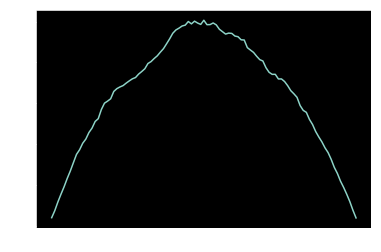

In [326]:
plt.plot(np.var(data,0))

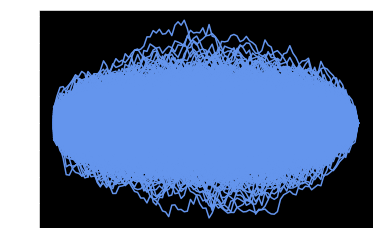

In [312]:
for i in range(data.shape[0]):
    plt.plot(mesh, data[i,:], color='cornflowerblue', alpha=1.0)

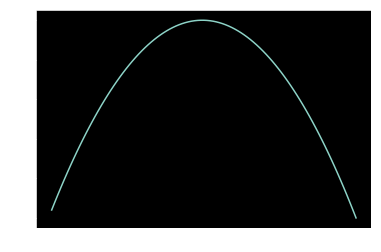

In [318]:
plt.plot(np.diag(BBcov))

In [129]:
def next_refresh_time(lambda_refresh, Z):
    return Z/lambda_refresh

def next_bounce_time_gaussian(x, v, C, Z):
    A = v @ lin.solve(C , x)
    B = v @ lin.solve(C , v)
    T0 = np.maximum(0.0, -A/B)
        
    tau = (-A + np.sqrt(A*A + 2*A*B*T0 + B*B*T0*T0 + 2*B*Z))/B
    
    return tau

def refresh_velocity_generalised(P):
    return np.random.multivariate_normal(np.zeros(P.shape[0]), P)

def bounce_generalised_test(v, x, P, Cinv):
    z = Cinv @ x
    A = np.dot(v, z)
    B = np.dot(z, P @ z)
    return v - 2.0*(A/B)* (P @ z)

def bounce_generalised(v, x, P, C):
    
   # z = Cinv @ x
    z = lin.solve(C, x)
    A = np.dot(v, z)
    B = np.dot(z, P @ z)
    return v - 2.0*(A/B)* (P @ z)


def bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples):
    d = x0.shape[0]
    P = lin.fractional_matrix_power(C, eta)
    
    sample_mesh  = np.linspace(0, T, num_samples)

    t = 0.0

    refresh_count = 0
    reflect_count = 0
    
    x_sample = np.zeros((len(sample_mesh), d))
    v_sample = np.zeros((len(sample_mesh), d))
    t_sample = np.zeros(len(sample_mesh))
    num_reflect = np.zeros(len(sample_mesh))
    num_refresh = np.zeros(len(sample_mesh))

    erg_av  = 0.0
    erg_var = 0.0

    sample_index = 0
    
    x = x0
    v = v0

    #progress bar code
    pbar = tqdm(total=num_samples)

    while (t < T):   
        tau_bounce = next_bounce_time_gaussian(x, v, C, -np.log(np.random.rand()))
        tau_refresh = next_refresh_time(lambda_refresh, -np.log(np.random.rand()))

        tau_min = np.minimum(tau_bounce, tau_refresh)
        
        #Generate the ergodic averages
        erg_av = erg_av + x*tau_min + 0.5*v*tau_min**2
        erg_var = erg_var +  x*x*tau_min + v*x*tau_min**2 + (1.0/3)*v*v*tau_min**3
        
        
        #Generate the regular sample of x, v, t along the trajectory
        while ((sample_index < num_samples) and (t + tau_min > sample_mesh[sample_index])):

            #print("%d : %2.12f, %2.12f"%(sample_index, t, tau_min))
            x_sample[sample_index,:] = x + (sample_mesh[sample_index] - t)*v
            v_sample[sample_index, :] = v
            t_sample[sample_index] = t
            
            num_reflect[sample_index] = reflect_count
            num_refresh[sample_index] = refresh_count
            
            reflect_count = 0
            refresh_count = 0
            sample_index = sample_index + 1
            
            pbar.update(1)
            
        #Store switching information

        t = t + tau_min
        x = x + tau_min*v

        if (tau_bounce < tau_refresh):
            v = bounce_generalised(v, x, P, C)
            reflect_count = reflect_count + 1
        else:
            v = refresh_velocity_generalised(P)
            refresh_count = refresh_count + 1
        
    erg_av = erg_av/t
    erg_var = erg_var/t - (erg_av)**2
    
    return(erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh)

In [234]:
C = BBcov[:]
x0 = np.zeros(C.shape[0])
v0 = np.ones(C.shape[0])

T = 1000000.0

lambda_refresh = 0.1
eta=5.0
num_samples = int(T/1e-1)

erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_generalised(C, x0, v0, lambda_refresh, eta, T, num_samples)


HBox(children=(IntProgress(value=0, max=10000000), HTML(value='')))

## Non Gaussian example:

We consider the case where :  
$$
    U(x)= \int_0^1 F(x(\tau))\,d\tau,
$$
where $F(x) = \frac{1}{2}(x^2-1)^2$.   Then
$$
    \langle v, \partial_x U(x)\rangle = \int_0^1 F'(x(\tau))v(\tau)\,d\tau,
$$
where $F(x) = 2x^3 - 2x$.  Then we have that
$$
    \lambda(x, w) = \langle w, \partial_x U(x) + C^{-1}x \rangle.
$$

Consider
$$
\langle w, \partial_x U(x + wt)\rangle_+ \leq 2 |w\cdot x^3-w\cdot x|+ t|6w\cdot w x^2-2w\cdot w| + 6t^2 |w\cdot w^2 x| + 2t^3|w\cdot w^3|
$$
Then 
$$
s(T) \leq  \frac{1}{2}T^4|w\cdot w^3| + 2T^3 |w\cdot w^2 x|+ T^2(|3w\cdot w x^2  - w\cdot w|) +  2T (|w\cdot  x^3 - w\cdot x|)  $$

In [20]:
def next_refresh_time(lambda_refresh, Z):
    return Z/lambda_refresh

def next_bounce_time_gaussian(x, v, C, Z):
    A = v @ lin.solve(C , x)
    B = v @ lin.solve(C , v)
    T0 = np.maximum(0.0, -A/B)
        
    tau = (-A + np.sqrt(A*A + 2*A*B*T0 + B*B*T0*T0 + 2*B*Z))/B
    
    return tau

def intensity_non_gaussian(x, v, tau, dx):
    return max(0.0, 2.0*np.dot(v, (x+ tau*v)**3 - (x+ tau*v))*dx)

def dominating_intensity_non_gaussian(x, v, tau, dx):
    T4 = np.dot(v, 2.0*v**3)*dx
    T3 = np.dot(v, 6.0*v**2 * x)*dx
    T2 = np.dot(v, 6.0*v * x**2 - 2.0*v)*dx
    T1 = 2.0*np.dot(v, x**3 - x)*dx
    
    return np.abs(T1) + tau*np.abs(T2) + tau*tau*np.abs(T3) + tau*tau*tau*np.abs(T4)


def next_bounce_time_non_gaussian(x, v, Z, dx):
    #Assemble coefficients.
    
    #Order 4 term
    T4 = 0.5*np.dot(v, v**3)
    T3 = 2.0*np.dot(v, v**2 * x)
    T2 = 3.0*np.dot(v, v * x**2) - np.dot(v, v)
    T1 = 2.0*np.dot(v, x**3 - x)
    
    p = [np.abs(T4)*dx, np.abs(T3)*dx, np.abs(T2)*dx, np.abs(T1)*dx, -Z]
    
    rts = np.roots(p)
    
    tau = np.real(rts[3])
    if (tau < 0):
        return np.inf
    else:
        return tau
        
def refresh_velocity_generalised(P):
    return np.random.multivariate_normal(np.zeros(P.shape[0]), P)

def bounce_generalised_nongaussian(v, x, P, C, dx):
    
    z = lin.solve(C, x) + 2.0*(x**3-x)*dx
    A = np.dot(v, z)
    B = np.dot(z, P @ z)
    return v - 2.0*(A/B)* (P @ z)


def bps_non_gaussian(C, x0, v0, lambda_refresh, eta, T, num_samples, dx):
    d = x0.shape[0]
    P = lin.fractional_matrix_power(C, eta)
    
    sample_mesh  = np.linspace(0, T, num_samples)

    t = 0.0

    refresh_count = 0
    reflect_count = 0
    
    x_sample = np.zeros((len(sample_mesh), d))
    v_sample = np.zeros((len(sample_mesh), d))
    t_sample = np.zeros(len(sample_mesh))
    num_reflect = np.zeros(len(sample_mesh))
    num_refresh = np.zeros(len(sample_mesh))

    erg_av  = 0.0
    erg_var = 0.0

    sample_index = 0
    
    x = x0
    v = v0
  
    #progress bar code
    pbar = tqdm(total=num_samples)

    while (t < T):   
        
        tau_non_gaussian_bounce = next_bounce_time_non_gaussian(x, v, -np.log(np.random.rand()), dx)
        tau_gaussian_bounce = next_bounce_time_gaussian(x, v, C, -np.log(np.random.rand()))
        tau_refresh = next_refresh_time(lambda_refresh, -np.log(np.random.rand()))
                
        tau_min = min(tau_gaussian_bounce, tau_refresh, tau_non_gaussian_bounce)
     #   print(tau_non_gaussian_bounce, tau_gaussian_bounce, tau_refresh, tau_min)

        
        #Generate the ergodic averages
        erg_av = erg_av + x*tau_min + 0.5*v*tau_min**2
        erg_var = erg_var +  x*x*tau_min + v*x*tau_min**2 + (1.0/3)*v*v*tau_min**3
        
        
        #Generate the regular sample of x, v, t along the trajectory
        while ((sample_index < num_samples) and (t + tau_min > sample_mesh[sample_index])):

            #print("%d : %2.12f, %2.12f"%(sample_index, t, tau_min))
            x_sample[sample_index,:] = x + (sample_mesh[sample_index] - t)*v
            v_sample[sample_index, :] = v
            t_sample[sample_index] = t
            
            num_reflect[sample_index] = reflect_count
            num_refresh[sample_index] = refresh_count
            
            reflect_count = 0
            refresh_count = 0
            sample_index = sample_index + 1
            pbar.update(1)
            
        #Store switching information

        index_min = np.argmin(np.array([tau_non_gaussian_bounce, tau_gaussian_bounce, tau_refresh]))
        
        if (index_min == 0):
            m = intensity_non_gaussian(x, v, tau_min, dx)
            
            #test with fd
            M = dominating_intensity_non_gaussian(x, v, tau_min, dx)
            v_new = v[:]
            
            r = np.random.rand()
            if (r < m/M):
                v_new = bounce_generalised_nongaussian(v, x + tau_min*v, P, C, dx)
                reflect_count = reflect_count + 1
        elif (index_min == 1):
            v_new = bounce_generalised_nongaussian(v, x + tau_min*v, P, C, dx)
            reflect_count = reflect_count + 1
        else:
            v_new = refresh_velocity_generalised(P)
            refresh_count = refresh_count + 1
            
        t = t + tau_min
        x = x + tau_min*v
        
        v = v_new[:]
        
   #     print(t)

        
    erg_av = erg_av/t
    erg_var = erg_var/t - (erg_av)**2
    
    return(erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh)

In [21]:
# #This is a nice test for the bounce operator

# C = BBcov[:]
# x0 = np.random.randn(C.shape[0])
# v0 = np.random.randn(C.shape[0])

# eta=3.0
# P = lin.fractional_matrix_power(C, eta)
# M = 10000

# x0 = np.random.randn(C.shape[0])

# v_post = np.zeros((M, P.shape[0]))
# for m in range(M):
#     v = np.random.multivariate_normal(np.zeros(P.shape[0]), P)
#     v_post[m,:] = bounce_generalised(v, x0, P, C)
    
# plt.plot(np.diag(np.cov(v_post.T)))
# plt.plot(np.diag(P), '--')

In [32]:
def compute_errors(erg_av, erg_var,x_sample, C, dx):
    Cinv=lin.inv(C)
    av_err = np.linalg.norm(erg_av)
    cv_err = np.mean(np.abs(np.mean((Cinv@x_sample.T + 2.0*dx*((x_sample.T)**3 - x_sample.T)).T,0)))
    
    return (av_err, cv_err)
    
def run_experiment_ng(N, eta, burnin, fname):
    
    lambda_refresh = 1.0
    R = 1.0
    dx = R/N
    
    mesh = np.linspace(0, R, N, endpoint=False)[1:]
    BBcov = np.zeros((len(mesh), len(mesh)))
    
    for i in range(len(mesh)):
        for j in range(len(mesh)):
            BBcov[i, j] = np.minimum(mesh[i]/R, mesh[j]/R) - mesh[i]*mesh[j]/(R*R)


    C = BBcov
    x0 = np.random.randn(C.shape[0])
    v0 = np.random.randn(C.shape[0])

    
    T = 100000.0
    num_samples = int(T)

    erg_av, erg_var, x_sample, v_sample, t_sample, num_reflect, num_refresh = bps_non_gaussian(C, x0, v0, lambda_refresh, eta, T, num_samples, dx)
    av_err,cv_err = compute_errors(erg_av, erg_var,x_sample, C, dx)
        
    print(x_sample.shape)
    x_sample=x_sample[burnin:,:]
    num_reflect= num_reflect[burnin:]
    
    plt.subplot(2,2,1)
    plt.plot(np.cumsum(x_sample[:,0])/np.arange(1, 1+ x_sample.shape[0]))

    plt.subplot(2,2,2)
    plt.plot(np.cumsum(num_reflect)/np.arange(1, 1+ len(num_reflect)))

    plt.subplot(2,2,3)
    plt.plot(st.acf(x_sample[:,0],unbiased=True))

    plt.suptitle("d = %d, eta = %1.2f, av_err = %f, cv_err = %f"%(N, eta, av_err, cv_err))
    plt.tight_layout()
    plt.savefig(fname+".png",dpi=199)
    
    np.savetxt(fname+".txt", (N, eta, av_err, cv_err, np.mean(num_reflect)))
    
    
    plt.clf()

In [33]:
run_experiment_ng(20, 0.0, 500, "figures/nd3_0");
run_experiment_ng(20, 1.0, 500, "figures/nd3_1");
run_experiment_ng(20, 2.0, 500, "figures/nd3_2");
run_experiment_ng(20, 3.0, 500, "figures/nd3_3");
run_experiment_ng(20, 4.0, 500, "figures/nd3_4");

run_experiment_ng(40, 0.0, 500, "figures/nd5_0");
run_experiment_ng(40, 1.0, 500, "figures/nd5_1");
run_experiment_ng(40, 2.0, 500, "figures/nd5_2");
run_experiment_ng(40, 3.0, 500, "figures/nd5_3");
run_experiment_ng(40, 4.0, 500, "figures/nd5_4");

run_experiment_ng(60, 0.0, 500, "figures/nd7_0");
run_experiment_ng(60, 1.0, 500, "figures/nd7_1");
run_experiment_ng(60, 2.0, 500, "figures/nd7_2");
run_experiment_ng(60, 3.0, 500, "figures/nd7_3");
run_experiment_ng(60, 4.0, 500, "figures/nd7_4");

run_experiment_ng(80, 0.0, 500, "figures/nd9_0");
run_experiment_ng(80, 1.0, 500, "figures/nd9_1");
run_experiment_ng(80, 2.0, 500, "figures/nd9_2");
run_experiment_ng(80, 3.0, 500, "figures/nd9_3");
run_experiment_ng(80, 4.0, 500, "figures/nd9_4");

run_experiment_ng(100, 0.0, 500, "figures/nd11_0");
run_experiment_ng(100, 1.0, 500, "figures/nd11_1");
run_experiment_ng(100, 2.0, 500, "figures/nd11_2");
run_experiment_ng(100, 3.0, 500, "figures/nd11_3");
run_experiment_ng(100, 4.0, 500, "figures/nd11_4");


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 19)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 19)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 19)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 19)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 19)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 39)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 39)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 39)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 39)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 39)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 59)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 59)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 59)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 59)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 59)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))


(100000, 79)


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [34]:
import glob
simulation_table = []
for fname in glob.glob('figures/nd*.txt', recursive=True):
    x = np.loadtxt(fname)
    simulation_table = simulation_table + [x]
    
simulation_table = np.vstack(simulation_table)
simulation_table = simulation_table[simulation_table[:,0].argsort()]

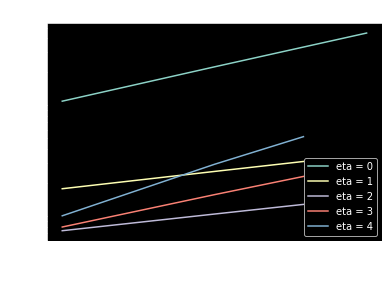

In [38]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,4], label='eta = 4')

plt.legend()
plt.xlabel("dimension")
plt.ylabel("flips per unit time")
plt.title("Number of flips per unit time")
#plt.show()
plt.savefig("figures/bps_ng_flips.png",dpi=199)

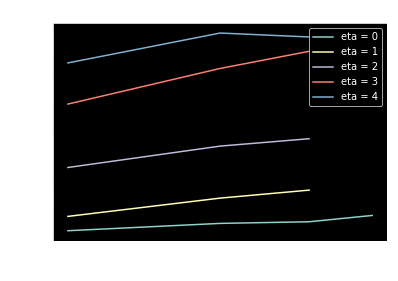

In [39]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,3], label='eta = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of cv error")
plt.title("Error in CV error")
#plt.show()
plt.savefig("figures/bps_ng_error_cv.png",dpi=199)

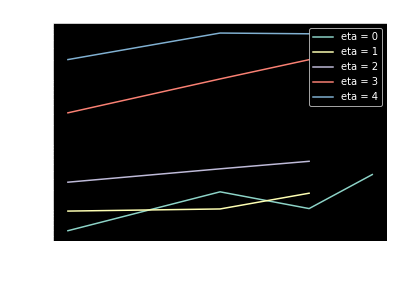

In [40]:
series = simulation_table[simulation_table[:,1]==0.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 0')

series = simulation_table[simulation_table[:,1]==1.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 1')

series = simulation_table[simulation_table[:,1]==2.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 2')

series = simulation_table[simulation_table[:,1]==3.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 3')

series = simulation_table[simulation_table[:,1]==4.0,:]
plt.loglog(series[:,0], series[:,2], label='eta = 4')

plt.legend()

plt.xlabel("dimension")
plt.ylabel("L2 norm of mean error")
plt.title("Error in marginal mean")
#plt.show()
plt.savefig("figures/bps_ng_error_mean.png",dpi=199)